In [2]:
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms, utils
import torch

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import numpy as np

In [3]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
BATCH_SIZE = 100

'''
Uncomment for MNIST

train_data = datasets.MNIST('./data', train=True, download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST('./data', train=False,
                           transform=transforms.ToTensor())
'''

'''
Uncomment for FashionMNIST
'''

train_data = datasets.FashionMNIST('./data', train=True, download=True,
                            transform=transforms.ToTensor())
test_data = datasets.FashionMNIST('./data', train=False,
                           transform=transforms.ToTensor())


train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=BATCH_SIZE, shuffle=True)



cpu


/home/mishal/.local/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.input_dim = 784
        self.latent_dim = 2
        self.latent_batch_size = 4
        self.input_batch_size = 1#BATCH_SIZE
        
        self.x_sigma = 1.5
        
        self.enc_lin1 = nn.Linear(784, 400)
        self.enc_lin2 = nn.Linear(400, 100)
        self.enc_lin3_mu = nn.Linear(100, self.latent_dim)
        self.enc_lin3_logvar = nn.Linear(100, self.latent_dim)
        
        self.dec_lin1 = nn.Linear(self.latent_dim, 100)
        self.dec_lin2 = nn.Linear(100, 400)
        self.dec_lin3 = nn.Linear(400, 784)
        
        self.sigm = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0)
    def decoder(self, z):
        dec_out1 = self.dropout(F.relu(self.dec_lin1(z)))
        dec_out2 = self.dropout(F.relu(self.dec_lin2(dec_out1)))
        dec_out = self.sigm(self.dec_lin3(dec_out2))
        return dec_out
        
    def encoder(self, x):
        enc_out1 = self.dropout(F.relu(self.enc_lin1(x)))
        enc_out2 = self.dropout(F.relu(self.enc_lin2(enc_out1)))
        enc_out_mu = self.enc_lin3_mu(enc_out2)
        enc_out_logvar = self.enc_lin3_logvar(enc_out2)
        return enc_out_mu, enc_out_logvar
    
    def reparam_trick(self, mu_z, logvar_z):
        sigma_z = torch.exp(logvar_z)
        eps = torch.rand_like(sigma_z)
        return mu_z + eps*sigma_z
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        mu_x, logvar_x = self.encoder(x)
        z_batch = self.reparam_trick(mu_x, logvar_x)
        recon_x_batch = self.decoder(z_batch)
        return recon_x_batch, mu_x, logvar_x

    def loss_function(self, x, recon_x_batch, mu_x, logvar_x):
        x = x.view(x.shape[0], -1)
        recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
        kl_div = 0.5*torch.sum(mu_x.pow(2) + logvar_x.exp() - logvar_x - 1)/self.input_batch_size
        return recon_loss + kl_div
    


In [249]:
#Skip this block if you want to see the output alone using already trained weights

vae = VAE().to(device)
#optimizer = optim.SGD(vae.parameters(), lr=0.005, weight_decay=1e-5)
optimizer = optim.Adam(vae.parameters())

vae.train()

for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        recon_x, mu_x, logvar_x = vae(inputs)
        loss = vae.loss_function(inputs, recon_x, mu_x, logvar_x)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 2057.946
[1,   400] loss: 1658.768
[1,   600] loss: 1613.370
[2,   200] loss: 1575.899
[2,   400] loss: 1548.751
[2,   600] loss: 1530.799
[3,   200] loss: 1514.822
[3,   400] loss: 1501.484
[3,   600] loss: 1494.231
[4,   200] loss: 1484.878
[4,   400] loss: 1471.888
[4,   600] loss: 1465.631
[5,   200] loss: 1459.149
[5,   400] loss: 1450.233
[5,   600] loss: 1447.230
[6,   200] loss: 1442.691
[6,   400] loss: 1433.271
[6,   600] loss: 1431.236
[7,   200] loss: 1427.810
[7,   400] loss: 1424.943
[7,   600] loss: 1418.927
[8,   200] loss: 1414.665
[8,   400] loss: 1412.508
[8,   600] loss: 1416.162
[9,   200] loss: 1405.365
[9,   400] loss: 1408.826
[9,   600] loss: 1401.189
[10,   200] loss: 1398.182
[10,   400] loss: 1400.750
[10,   600] loss: 1400.228
[11,   200] loss: 1391.099
[11,   400] loss: 1390.988
[11,   600] loss: 1395.521
[12,   200] loss: 1383.440
[12,   400] loss: 1387.607
[12,   600] loss: 1385.895
[13,   200] loss: 1381.514
[13,   400] loss: 1383.233
[

In [6]:
#Uncomment for MNIST weights
#PATH = './mnist_net_avg10_2.pth' 

#Uncomment for Fashion MNIST weights
PATH = './fmnist_net_avg10_2.pth'

#Uncomment to save after training
#torch.save(vae.state_dict(), PATH)

vae_n = VAE()
vae_n.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

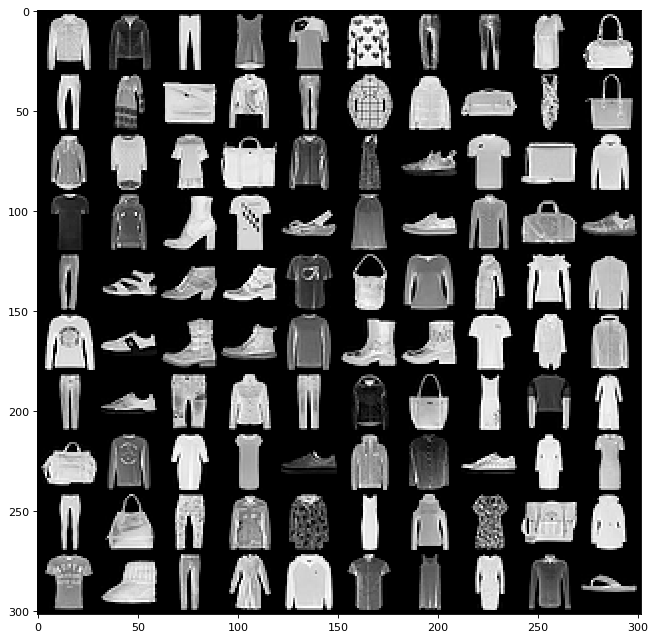

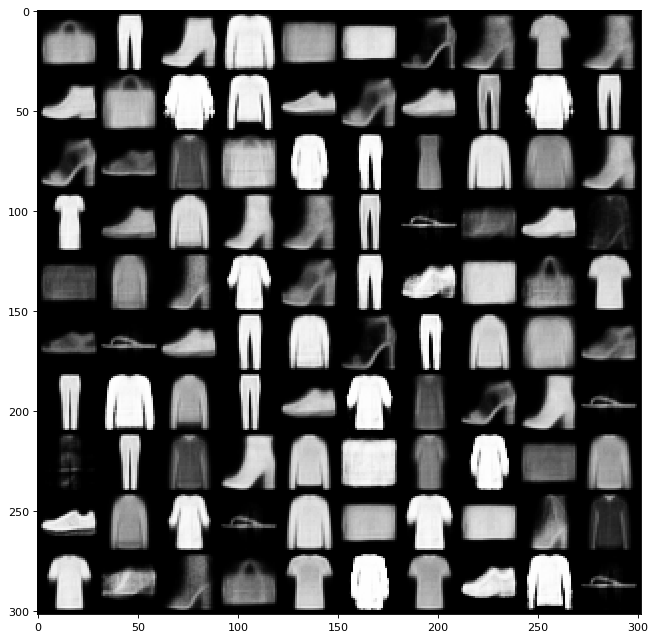

In [7]:
z = torch.randn((100,vae_n.latent_dim))

from matplotlib.pyplot import figure

#Print 100 samples from the dataset
figure(figsize=(10, 10), dpi=80)
image_data, labels = next(iter(train_loader))
image_data = image_data[:,None,:]
image_data = torch.reshape(image_data,(100,1,28,28))
grid_image_data = utils.make_grid(image_data, nrow=10)
grid_image_data_np = grid_image_data.cpu().detach().numpy().transpose(1,2,0)
plt.imshow(grid_image_data_np)
#plt.savefig('mnist_data')
plt.show()

#Print 100 samples using the VAE
figure(figsize=(10, 10), dpi=80)
image_vae = vae_n.decoder(z)
image_vae = image_vae[:, None, :]
image_vae = torch.reshape(image_vae,(100,1,28,28))
grid_image_vae = utils.make_grid(image_vae, nrow=10)
grid_image_vae_np = grid_image_vae.cpu().detach().numpy().transpose(1,2,0)
plt.imshow(grid_image_vae_np)
#plt.savefig('mnist_vae')
plt.show()
